# Segmenting and Clustering Neighborhoods in the US

###### Perpared by Enrique Puente for Coursera's Applied Data Science Capston Project

The United States has  a housing problem for some time now. Housing prices keep increasing as restrictions hinder  development in the main cities. Meanwhile suburban areas are deemed unattractive as there's "not enough going on" there. One view of this notion could be the lack of public venues for people to enjoy. The thesis is that there must be neighborhoods in the United States that may qualify for home pursuers criteria and may not necessarily be in such densely populated areas. This study intends to analyze areas in the US and describe them by means of the venues around those areas and relative pricing. By the end of this analysis we should have uncovered the best alternatives for an audience that wants to relocate after their job allows for remote working.

## 1.0 Download and Import Libraries

In [22]:
# Import Librarires
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# !conda install -c conda-forge googlemaps --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut
import googlemaps

import time

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# !conda install -c conda-forge pandas_bokeh --yes
#import pandas_bokeh

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2.0 Data Download

### 2.1 Loading Data from CSV (Zillow Provided)

The following cell uses Pandas' "read_csv" method for pulling table from CSV file. The file contains a list of nighborhoods associated with cities and states across the US. The file also contains the Zillow Home Value Index (ZHVI), a smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. According to Zillow. Because the stock of homes was fixed over time, month-over-month growth under these assumptions could be interpreted as appreciation of the typical home.
For more infromation access Zillow's methodology secription at the following link: https://www.zillow.com/research/zhvi-methodology-2019-highlights-26221/

In [186]:
# Load All Homes CSV file
Neighborhood_Zhvi_AllHomes = pd.read_csv('Neighborhood_Zhvi_AllHomes.csv',index_col=[5,7,8,6,2])
Neighborhood_Zhvi_AllHomes.head()

,,,,,RegionID,SizeRank,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
State,Metro,CountyName,City,RegionName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TX,Dallas-Fort Worth-Arlington,Dallas County,Dallas,Northeast Dallas,274772,0,Neighborhood,TX,134197.0,134246.0,134828.0,135458.0,136178.0,136311.0,135938.0,135741.0,135548.0,136007.0,135947.0,136036.0,136103.0,136474.0,136100.0,135830.0,135445.0,135959.0,137003.0,137943.0,138607.0,138708.0,139321.0,139986.0,139978.0,139698.0,139529.0,139668.0,139828.0,139702.0,139866.0,139817.0,140369.0,140185.0,140342.0,

In [187]:
# Load 2-Bedroom Homes CSV file
Neighborhood_Zhvi_1bedroom = pd.read_csv('Neighborhood_Zhvi_1bedroom.csv',index_col=[5,7,8,6,2])
Neighborhood_Zhvi_2bedroom = pd.read_csv('Neighborhood_Zhvi_2bedroom.csv',index_col=[5,7,8,6,2])
Neighborhood_Zhvi_3bedroom = pd.read_csv('Neighborhood_Zhvi_3bedroom.csv',index_col=[5,7,8,6,2])

The remaining columns will be preserved in a separate DataFrame 'USneighb', a separate column will be created to aggregate address infromation in order to query a coordinate location object from the GeoPy library.

In [4]:
All_RegionsDF = Neighborhood_Zhvi_AllHomes.loc[:,'RegionID':'SizeRank']
All_RegionsDF['Address'] = Neighborhood_Zhvi_AllHomes.index.to_frame()[['RegionName', 'City', 'State']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
All_RegionsDF['AllHPrice'] = Neighborhood_Zhvi_AllHomes.iloc[:,[-1]]
All_RegionsDF['1brPrice'] = Neighborhood_Zhvi_1bedroom.iloc[:,[-1]]
All_RegionsDF['2brPrice'] = Neighborhood_Zhvi_2bedroom.iloc[:,[-1]]
All_RegionsDF['3brPrice'] = Neighborhood_Zhvi_3bedroom.iloc[:,[-1]]
print('Total of {} neighborhoods in the US.'.format(len(All_RegionsDF)))
All_RegionsDF.head()

Total of 16147 neighborhoods in the US.


,,,,,RegionID,SizeRank,Address,AllHPrice,1brPrice,2brPrice,3brPrice
State,Metro,CountyName,City,RegionName,,,,,,,
TX,Dallas-Fort Worth-Arlington,Dallas County,Dallas,Northeast Dallas,274772,0,"Northeast Dallas, Dallas, TX",330354.0,101742.0,249511.0,328159.0
AZ,Phoenix-Mesa-Scottsdale,Maricopa County,Phoenix,Maryvale,112345,1,"Maryvale, Phoenix, AZ",200393.0,97275.0,170912.0,206442.0
NV,Las Vegas-Henderson-Paradise,Clark County,Las Vegas,Paradise,192689,2,"Paradise, Las Vegas, NV",276646.0,118713.0,185802.0,279248.0
NY,New York-Newark-Jersey City,New York County,New York,Upper West Side,270958,3,"Upper West Side, New York, NY",1208018.0,759513.0,1552897.0,2553708.0
CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Los Angeles,South Los Angeles,118208,4,"South Los Angeles, Los Angeles, CA",545001.0,468154.0,511306.0,562622.0


In [5]:
All_RegionsDF.xs(('Los Angeles-Long Beach-Anaheim'),level='Metro',axis=0).head()

RegionID  \
State CountyName         City        RegionName                        
CA    Los Angeles County Los Angeles South Los Angeles        118208   
                                     Southeast Los Angeles    268496   
                                     Hollywood                 32059   
                         Long Beach  North Long Beach         276476   
                         Los Angeles Mid City                 274514   

                                                            SizeRank  \
State CountyName         City        RegionName                        
CA    Los Angeles County Los Angeles South Los Angeles             4   
                                     Southeast Los Angeles         8   
                                     Hollywood                    18   
                         Long Beach  North Long Beach             52   
                         Los Angeles Mid City                     62   

                                                                                           Address  \
State CountyName         City        RegionName                                                      
CA    Los Angeles County Los Angeles South Los Angeles          South Los Angeles, Los Angeles, CA   
                                     Southeast Los Angeles  Southeast Los Angeles, Los Angeles, CA   
                                     Hollywood                          Hollywood, Los Angeles, CA   
                         Long Beach  North Long Beach             North Long Beach, Long Beach, CA   
                         Los Angeles Mid City                            Mid City, Los Angeles, CA   

                                                            AllHPrice  \
State CountyName         City        RegionName                         
CA    Los Angeles County Los Angeles South Los Angeles       545001.0   
                                     Southeast Los Angeles   449580.0   
                                     Hollywood               963133.0   
                         Long Beach  North Long Beach        506153.0   
                         Los Angeles Mid City               1175624.0   

                                                            1brPrice  \
State CountyName         City        RegionName                        
CA    Los Angeles County Los Angeles South Los Angeles      468154.0   
                                     Southeast Los Angeles  389953.0   
                                     Hollywood              653369.0   
                         Long Beach  North Long Beach       387551.0   
                         Los Angeles Mid City               747884.0   

                                                            2brPrice  \
State CountyName         City        RegionName                        
CA    Los Angeles County Los Angeles South Los Angeles      511306.0   
                                     Southeast Los Angeles  423958.0   
                                     Hollywood              861984.0   
                         Long Beach  North Long Beach       474324.0   
                         Los Angeles Mid City               906907.0   

                                                             3brPrice  
State CountyName         City        RegionName                        
CA    Los Angeles County Los Angeles South Los Angeles       562622.0  
                                     Southeast Los Angeles   455695.0  
                                     Hollywood              1187528.0  
                         Long Beach  North Long Beach        525357.0  
                         Los Angeles Mid City               1210848.0

In [284]:
All_RegionsDF[['AllHPrice','1brPrice','2brPrice','3brPrice']].groupby(level='State').mean().sort_values(by=['AllHPrice'],ascending=False).head(10)

,AllHPrice,1brPrice,2brPrice,3brPrice
State,,,,
WY,969604.750000,492096.000000,664275.500000,1.012321e+06
CA,910568.599167,590585.780558,708930.135613,9.149227e+05
HI,721668.000000,808089.800000,797324.600000,9.088964e+05
DC,708519.031746,383471.637500,597942.413793,7.872987e+05
WA,595548.571429,396322.886364,477075.245361,5.953605e+05
MA,572044.753623,354557.405128,474550.538760,6.378610e+05
CO,548832.819578,336264.068807,418669.776549,5.384219e+05
NY,519062.426804,410960.249240,473606.567265,6.540345e+05
OR,481554.191571,338799.243243,384284.567901,4.756275e+05


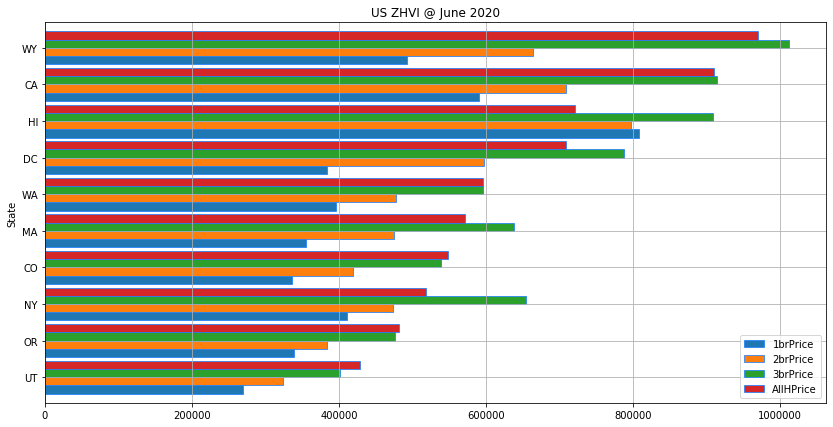

In [6]:
All_RegionsDF[['1brPrice','2brPrice','3brPrice','AllHPrice']].groupby(level='State').mean().sort_values(by=['AllHPrice'],ascending=True).tail(10).plot.barh(title='US ZHVI @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

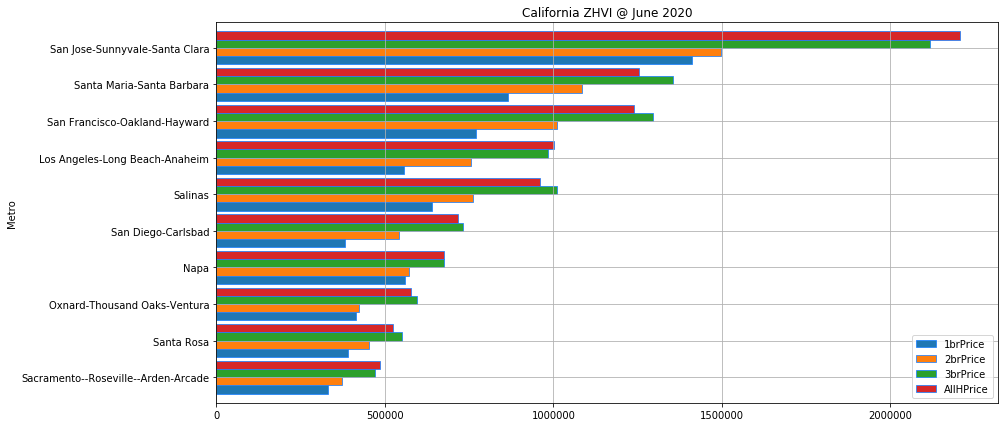

In [603]:
All_RegionsDF.loc[idx['CA',:,:,:,:],['1brPrice','2brPrice','3brPrice','AllHPrice']].groupby(level='Metro').mean().sort_values(by=['AllHPrice'],ascending=True).tail(10).plot.barh(title='California ZHVI @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

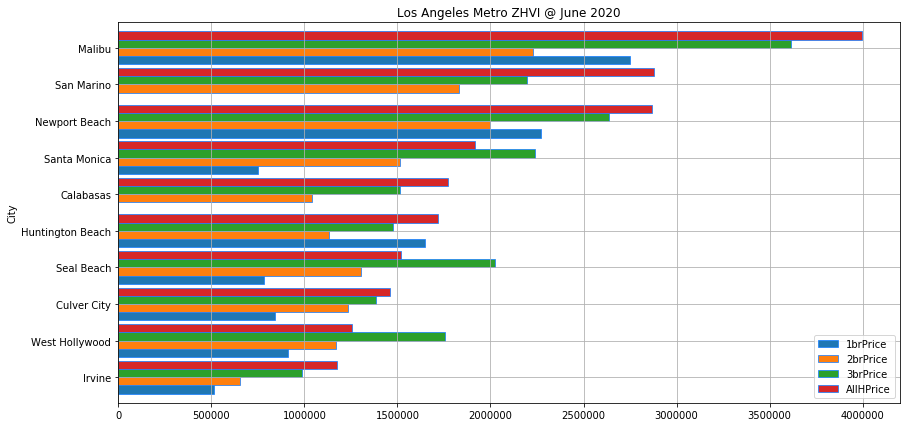

In [113]:
idx = pd.IndexSlice
All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['1brPrice','2brPrice','3brPrice','AllHPrice']].groupby(level='City').mean().sort_values(by=['AllHPrice'],ascending=True).tail(10).plot.barh(title='Los Angeles Metro ZHVI @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

(-10, 1500000)

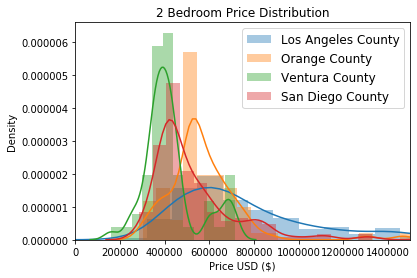

In [875]:
# Price Histograms
# All_RegionsDF.loc[idx['CA',:,:,:,:],['1brPrice','2brPrice','3brPrice','AllHPrice']].reset_index().hist(bins=50, grid=True, figsize=(14,7))
# All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['1brPrice','2brPrice','3brPrice','AllHPrice']].hist(bins=50, grid=True, figsize=(14,7))
sns.distplot(All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim','Los Angeles County',:,:],['2brPrice']], label='Los Angeles County')
sns.distplot(All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim','Orange County',:,:],['2brPrice']], label='Orange County')
sns.distplot(All_RegionsDF.loc[idx['CA',:,'Ventura County',:,:],['2brPrice']], label='Ventura County')
sns.distplot(All_RegionsDF.loc[idx['CA',:,'San Diego County',:,:],['2brPrice']], label='San Diego County')
plt.legend(prop={'size': 12})
plt.title('2 Bedroom Price Distribution')
plt.xlabel('Price USD ($)')
plt.ylabel('Density')
plt.xlim(-10, 1500000)

In [10]:
# Standardized prices by County
All_RegionsDF[['AllHPriceStd','3brPriceStd','2brPriceStd','1brPriceStd']] = All_RegionsDF[['AllHPrice','3brPrice','2brPrice','1brPrice']].groupby(level=('State','CountyName'), axis=0).apply(lambda x: (x-np.mean(x))/np.std(x))

In [11]:
All_RegionsDF.loc[idx['CA',:,:,:,:],['AllHPrice','AllHPriceStd']].sort_values(by=['AllHPriceStd'],ascending=False).head(20)

AllHPrice  \
State Metro                            CountyName           City          RegionName                                  
CA    Los Angeles-Long Beach-Anaheim   Orange County        Irvine        Shady Canyon                    5565700.0   
      Oxnard-Thousand Oaks-Ventura     Ventura County       Ventura       Taylor Ranch                    3487088.0   
      Los Angeles-Long Beach-Anaheim   Los Angeles County   Malibu        Paradise Cove                   5874287.0   
                                                                          Sycamore Park                   5247669.0   
      San Francisco-Oakland-Hayward    Alameda County       Fremont       Mission Hills                   2811791.0   
      Los Angeles-Long Beach-Anaheim   Los Angeles County   Malibu        Point Dume                      4874495.0   
                                                            San Marino    Lacy Estates                    4701365.0   
      Riverside-San Bernardino-Ontario Riverside County     Palm Springs  Old Las Palmas                  1828098.0   
      Salinas                          Monterey County      Pacific Grove Spanish Bay                     3377919.0   
      San Francisco-Oakland-Hayward    San Francisco County San Francisco Presidio Heights                4969189.0   
      Los Angeles-Long Beach-Anaheim   Los Angeles County   Santa Monica  North of Montana                4233745.0   
      Riverside-San Bernardino-Ontario Riverside County     Palm Springs  Vista Las Palmas                1601906.0   
      Santa Maria-Santa Barbara        Santa Barbara County Santa Barbara Campanil                        3351007.0   
      San Francisco-Oakland-Hayward    Alameda County       Fremont       Vineyards-Avalon                2339443.0   
      Stockton-Lodi                    San Joaquin County   Tracy         Mountain House                   653964.0   
      San Diego-Carlsbad               San Diego County     San Diego     North Island Naval Air Station  1898414.0   
      San Francisco-Oakland-Hayward    San Mateo County     Menlo Park    Central Menlo Park              4228766.0   
      Los Angeles-Long Beach-Anaheim   Los Angeles County   Malibu        Malibu Park                     3799221.0   
                                                            Los Angeles   Bel Air                         3742258.0   
      Riverside-San Bernardino-Ontario Riverside County     Palm Springs  Andreas Hills                   1490933.0   

                                                                                                          AllHPriceStd  
State Metro                            CountyName           City          RegionName                                    
CA    Los Angeles-Long Beach-Anaheim   Orange County        Irvine        Shady Canyon                        8.315431  
      Oxnard-Thousand Oaks-Ventura     Ventura County       Ventura       Taylor Ranch                        7.693152  
      Los Angeles-Long Beach-Anaheim   Los Angeles County   Malibu        Paradise Cove                       6.532955  
                                                                          Sycamore Park                       5.683160  
      San Francisco-Oakland-Hayward    Alameda County       Fremont       Mission Hills                       5.252873  
      Los Angeles-Long Beach-Anaheim   Los Angeles County   Malibu        Point Dume                          5.177075  
                                                            San Marino    Lacy Estates                        4.942283  
      Riverside-San Bernardino-Ontario Riverside County     Palm Springs  Old Las Palmas                      4.866489  
      Salinas                          Monterey County      Pacific Grove Spanish Bay                         4.817722  
      San Francisco-Oakland-Hayward    San Francisco County San Francisco Presidio Heights                    4.632718  
      Los Angeles-Long Beach-Anahei

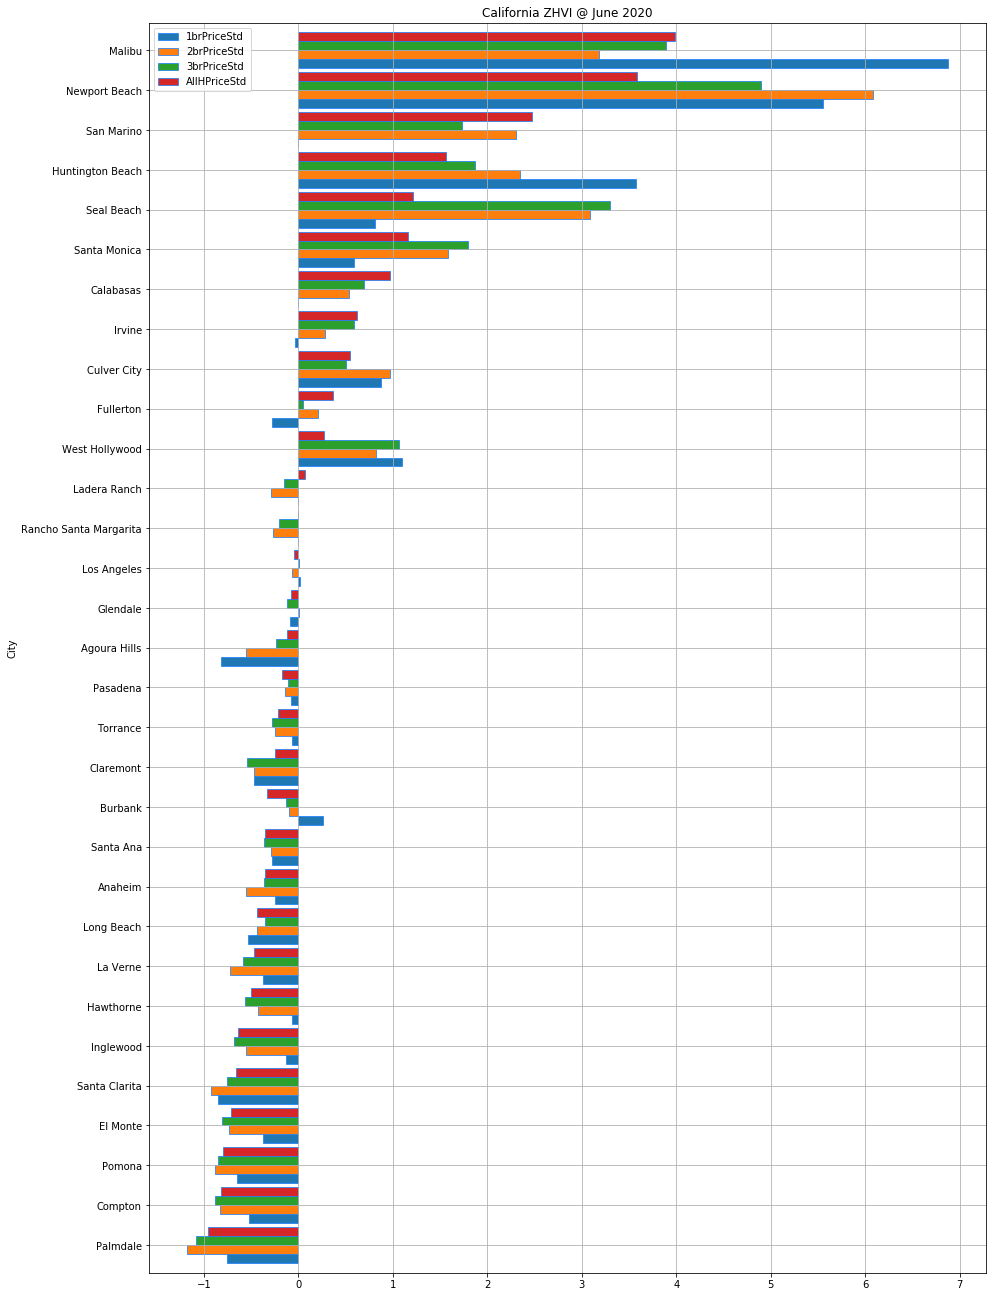

In [13]:
All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['1brPriceStd','2brPriceStd','3brPriceStd','AllHPriceStd']].groupby(level='City').mean().sort_values(by=['AllHPriceStd'],ascending=True).plot.barh(title='California ZHVI @ June 2020', grid=True, figsize=(15,23), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

In [12]:
All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['2brPrice','2brPriceStd','AllHPrice','AllHPriceStd']].sort_values(by=['2brPriceStd'],ascending=True).head(5)

2brPrice  \
State Metro                          CountyName         City      RegionName                        
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Palmdale  Lake Los Angeles       206530.0   
                                     Orange County      Santa Ana Lyon Street            301283.0   
                                     Los Angeles County Palmdale  Desert View Highlands  251447.0   
                                     Orange County      Santa Ana Downtown               316222.0   
                                                                  Lacy                   328210.0   

                                                                                         2brPriceStd  \
State Metro                          CountyName         City      RegionName                           
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Palmdale  Lake Los Angeles         -1.328643   
                                     Orange County      Santa Ana Lyon Street              -1.242759   
                                     Los Angeles County Palmdale  Desert View Highlands    -1.228348   
                                     Orange County      Santa Ana Downtown                 -1.178288   
                                                                  Lacy                     -1.126552   

                                                                                         AllHPrice  \
State Metro                          CountyName         City      RegionName                         
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Palmdale  Lake Los Angeles        244064.0   
                                     Orange County      Santa Ana Lyon Street             300835.0   
                                     Los Angeles County Palmdale  Desert View Highlands   291913.0   
                                     Orange County      Santa Ana Downtown                293177.0   
                                                                  Lacy                    452215.0   

                                                                                         AllHPriceStd  
State Metro                          CountyName         City      RegionName                           
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Palmdale  Lake Los Angeles          -1.102539  
                                     Orange County      Santa Ana Lyon Street               -0.915075  
                                     Los Angeles County Palmdale  Desert View Highlands     -1.037648  
                                     Orange County      Santa Ana Downtown                  -0.928501  
                                                                  Lacy                      -0.649671

In [15]:
All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['1brPrice','1brPriceStd','AllHPrice','AllHPriceStd']].sort_values(by=['1brPriceStd'],ascending=True).head(5)

1brPrice  \
State Metro                          CountyName         City          RegionName                    
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Los Angeles   Panorama City      243804.0   
                                                        Long Beach    Washington School  254191.0   
                                                        Santa Clarita Newhall            255691.0   
                                                                      Canyon Country     258984.0   
                                                        Los Angeles   Winnetka           264838.0   

                                                                                         1brPriceStd  \
State Metro                          CountyName         City          RegionName                       
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Los Angeles   Panorama City        -1.001161   
                                                        Long Beach    Washington School    -0.968526   
                                                        Santa Clarita Newhall              -0.963813   
                                                                      Canyon Country       -0.953467   
                                                        Los Angeles   Winnetka             -0.935074   

                                                                                         AllHPrice  \
State Metro                          CountyName         City          RegionName                     
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Los Angeles   Panorama City       526859.0   
                                                        Long Beach    Washington School   389678.0   
                                                        Santa Clarita Newhall             545894.0   
                                                                      Canyon Country      556728.0   
                                                        Los Angeles   Winnetka            622104.0   

                                                                                         AllHPriceStd  
State Metro                          CountyName         City          RegionName                       
CA    Los Angeles-Long Beach-Anaheim Los Angeles County Los Angeles   Panorama City         -0.719024  
                                                        Long Beach    Washington School     -0.905063  
                                                        Santa Clarita Newhall               -0.693209  
                                                                      Canyon Country        -0.678516  
                                                        Los Angeles   Winnetka              -0.589856

In [13]:
All_RegionsDF.xs('San Diego', level='City', axis=0).sort_values(by=['2brPrice'],ascending=False)

RegionID  \
State Metro              CountyName       RegionName                                 
CA    San Diego-Carlsbad San Diego County North Island Naval Air Station    403247   
                                          Horton Plaza                      268215   
                                          Sunset Cliffs                     118387   
                                          North City                        274698   
                                          Wooded Area                       276122   
                                          Mission Beach                     116638   
                                          Del Mar Heights                   114649   
                                          Core-Columbia                     273349   
                                          La Jolla                           46087   
                                          Ocean Beach                       117021   
                                          La Playa                          116026   
                                          Loma Portal                       116266   
                                          Burlingame                        403244   
                                          Harborview                        268203   
                                          Roseville - Fleet Ridge           117770   
                                          Marina                            276439   
                                          Mission Hills                     116647   
                                          Balboa Park                       268012   
                                          Pacific Beach                     117156   
                                          South Park                        118211   
                                          Midtown                           268297   
                                          Bankers Hill                      268393   
                                          Black Mountain Ranch              268024   
                                          Carmel Valley                     273140   
                                          Kensington                        274174   
                                          Adams North                       403231   
                                          East Village                      273571   
                                          Bay Park                          113657   
                                          Sorrento Valley                   275401   
                                          North Park                        274717   
                                          Gaslamp Quarter                   273808   
                                          Torrey Preserve                   403249   
                                          Cortez Hill                       273355   
                                          North Clairemont                  116921   
                                          Point Loma Heights                268410   
                                          University City                   118673   
                                          Hillcrest                         115622   
                                          Little Italy                      268259   
                                          Normal Heights                    116914   
                                          Clairemont Mesa West              403250   
                                          Midway District                   274527   
                                          University Heights                275997   
                                          Torrey Highlands                  268525   
                                          Bay Ho                            268015   
                                          Old Town                          274893   
                                

Next we will extract the date columns and transpose them to create a common timeseries accross all RegionID's.

In [188]:
zhvi_timeseries = pd.concat([Neighborhood_Zhvi_AllHomes.loc[:,'1996-01-31':].T,Neighborhood_Zhvi_3bedroom.loc[:,'1996-01-31':].T,Neighborhood_Zhvi_2bedroom.loc[:,'1996-01-31':].T,Neighborhood_Zhvi_1bedroom.loc[:,'1996-01-31':].T], keys=['AllHomes','3br','2br','1br'], names=['Type'], axis=1)
zhvi_timeseries = zhvi_timeseries.reorder_levels(['State', 'Metro', 'CountyName', 'City', 'RegionName','Type'],axis=1)
zhvi_timeseries.index = pd.to_datetime(zhvi_timeseries.index)

In [189]:
zhvi_timeseries.loc['2020',idx['CA',:,:,'Huntington Beach',:]].head()

State                                  CA                                  \
Metro      Los Angeles-Long Beach-Anaheim                                   
CountyName                  Orange County                                   
City                     Huntington Beach                                   
RegionName                   Sunset Beach Huntington Harbour Sunset Beach   
Type                             AllHomes           AllHomes          3br   
2020-01-31                      1793890.0          1595774.0    1589441.0   
2020-02-29                      1811676.0          1603954.0    1600951.0   
2020-03-31                      1823970.0          1610514.0    1608578.0   
2020-04-30                      1817004.0          1614321.0    1600721.0   

State                                                                       
Metro                                                                       
CountyName                                                                  
City                                                                        
RegionName Huntington Harbour Sunset Beach Huntington Harbour Sunset Beach  
Type                      3br          2br                2br          1br  
2020-01-31          1335320.0    1449328.0           780563.0    1675042.0  
2020-02-29          1344542.0    1465088.0           787601.0    1669066.0  
2020-03-31          1350041.0    1472483.0           794099.0    1659818.0  
2020-04-30          1353106.0    1467585.0           798550.0    1648876.0

In [304]:
cumreturn = zhvi_timeseries['2010':'2020'].xs('2br', level='Type', axis=1).groupby(level='State', axis=1).mean().apply(lambda x: np.cumsum(np.clip(np.diff(x)/x[1:],0,2000))*100, axis=0)
# cumreturn = zhvi_timeseries['2010':'2020'].xs(('Chula Vista','AllHomes'), level=('City','Type'), axis=1).apply(lambda x: np.clip(np.cumsum(np.diff(x)/x[1:]),0,2000)*100, axis=0)

Text(0.5, 0, 'Years')

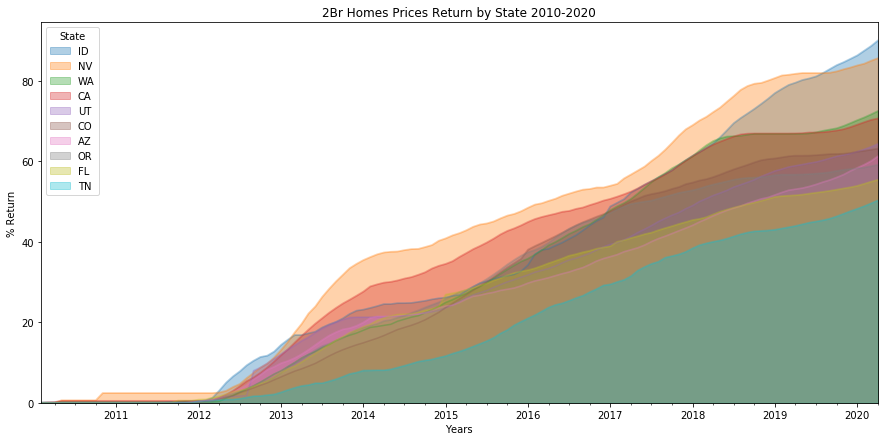

In [305]:
ax = cumreturn.sort_values(by='2020-04-30',axis=1,ascending=False).iloc[:,0:10].plot(kind='area', alpha=0.35, figsize=(15, 7),stacked=False)
ax.set_title('2Br Homes Prices Return by State 2010-2020')
ax.set_ylabel('% Return')
ax.set_xlabel('Years')

### Price Timeseries Statistics

The primary reason why so many people consider their house to be an investment. The whole notion rises and falls on the future value of the property. During times when the value of the house increases, people commonly think of their houses as investments.

But during the financial meltdown, and particularly in certain markets, not only did property values not increase, but most fell. Some fell spectacularly. For people in that situation, not only was their house not an investment, but it had become a major liability.

Calculation of monthly appreciation rate and volatility.

In [17]:
zhvi_timeseries['2010':'2020'].xs('CA', level='State', axis=1).groupby(level=['Metro'],axis=1).mean().apply(lambda x: 12*100*np.mean(np.diff(x)/x[1:]), axis=0).sort_values(ascending=False).head()

Metro
Stockton-Lodi                       7.258934
Riverside-San Bernardino-Ontario    7.014133
San Jose-Sunnyvale-Santa Clara      6.208265
San Francisco-Oakland-Hayward       6.130791
Vallejo-Fairfield                   5.933565
dtype: float64

In [19]:
All_RegionsDF['Sigma10Y'] = zhvi_timeseries['2010':'2020'].xs('AllHomes', level='Type', axis=1).apply(lambda x: np.sqrt(np.mean((np.diff(x)**2)/(x[1:]**2))), axis=0)
All_RegionsDF['Return10Y'] = zhvi_timeseries['2010':'2020'].xs('AllHomes', level='Type', axis=1).apply(lambda x: (30*(np.log(x[-1])-np.log(x[0])))/(np.timedelta64(x.index[-1]-x.index[0],'D').astype(int)), axis=0)
All_RegionsDF['SR10Y'] = All_RegionsDF['Return10Y']/All_RegionsDF['Sigma10Y']

In [872]:
All_RegionsDF.iloc[:,(slice(-10,-2))].sort_values(by=['Return10Y'],ascending=False).head(10)

Sigma10Y  \
State Metro                          CountyName         City           RegionName                      
CA    Los Angeles-Long Beach-Anaheim Los Angeles County San Marino     Lower Huntington     0.015477   
                                                                       Upper East Side      0.015220   
                                                                       East Village         0.015086   
                                                                       Mission District     0.014285   
                                                                       Library District     0.014187   
      San Francisco-Oakland-Hayward  Alameda County     Oakland        Trestle Glen         0.015384   
      Los Angeles-Long Beach-Anaheim Los Angeles County Santa Monica   Northeast            0.013731   
TX    Dallas-Fort Worth-Arlington    Dallas County      Dallas         Winnetka Heights     0.016334   
CA    San Francisco-Oakland-Hayward  Alameda County     Oakland        Crocker Highlands    0.015331   
      Los Angeles-Long Beach-Anaheim Los Angeles County West Hollywood West Hollywood West  0.014519   

                                                                                            Return10Y  \
State Metro                          CountyName         City           RegionName                       
CA    Los Angeles-Long Beach-Anaheim Los Angeles County San Marino     Lower Huntington      0.013457   
                                                                       Upper East Side       0.013396   
                                                                       East Village          0.013175   
                                                                       Mission District      0.012539   
                                                                       Library District      0.012196   
      San Francisco-Oakland-Hayward  Alameda County     Oakland        Trestle Glen          0.012108   
      Los Angeles-Long Beach-Anaheim Los Angeles County Santa Monica   Northeast             0.011726   
TX    Dallas-Fort Worth-Arlington    Dallas County      Dallas         Winnetka Heights      0.011652   
CA    San Francisco-Oakland-Hayward  Alameda County     Oakland        Crocker Highlands     0.011651   
      Los Angeles-Long Beach-Anaheim Los Angeles County West Hollywood West Hollywood West   0.011430   

                                                                                               SR10Y  \
State Metro                          CountyName         City           RegionName                      
CA    Los Angeles-Long Beach-Anaheim Los Angeles County San Marino     Lower Huntington     0.869507   
                                                                       Upper East Side      0.880194   
                                                                       East Village         0.873335   
                                                                       Mission District     0.877740   
                                                                       Library District     0.859672   
      San Francisco-Oakland-Hayward  Alameda County     Oakland        Trestle Glen         0.787062   
      Los Angeles-Long Beach-Anaheim Los Angeles County Santa Monica   Northeast            0.853973   
TX    Dallas-Fort Worth-Arlington    Dallas County      Dallas         Winnetka Heights     0.713356   
CA    San Francisco-Oakland-Hayward  Alameda County     Oakland        Crocker Highlands    0.759989   
      Los Angeles-Long Beach-Anaheim Los Angeles County West Hollywood West Hollywood West  0.787221   

                                                                                            Sigma20Y  \
State Metro                          CountyName         City           RegionName                      
CA    Los Angeles-Long Beach-Anaheim Los Angeles County San Marino     Lower Huntington     0.013371   
                     

In [21]:
All_RegionsDF['Sigma20Y'] = zhvi_timeseries['2000':'2020'].xs('AllHomes', level='Type', axis=1).apply(lambda x: np.sqrt(np.mean((np.diff(x)**2)/(x[1:]**2))), axis=0)
All_RegionsDF['Return20Y'] = zhvi_timeseries['2000':'2020'].xs('AllHomes', level='Type', axis=1).apply(lambda x: (30*(np.log(x[-1])-np.log(x[0])))/(np.timedelta64(x.index[-1]-x.index[0],'D').astype(int)), axis=0)
All_RegionsDF['SR20Y'] = All_RegionsDF['Return20Y']/All_RegionsDF['Sigma20Y']
All_RegionsDF['Sigma5Y'] = zhvi_timeseries['2015':'2020'].xs('AllHomes', level='Type', axis=1).apply(lambda x: np.sqrt(np.mean((np.diff(x)**2)/(x[1:]**2))), axis=0)
All_RegionsDF['Return5Y'] = zhvi_timeseries['2015':'2020'].xs('AllHomes', level='Type', axis=1).apply(lambda x: (30*(np.log(x[-1])-np.log(x[0])))/(np.timedelta64(x.index[-1]-x.index[0],'D').astype(int)), axis=0)
All_RegionsDF['SR5Y'] = All_RegionsDF['Return5Y']/All_RegionsDF['Sigma5Y']

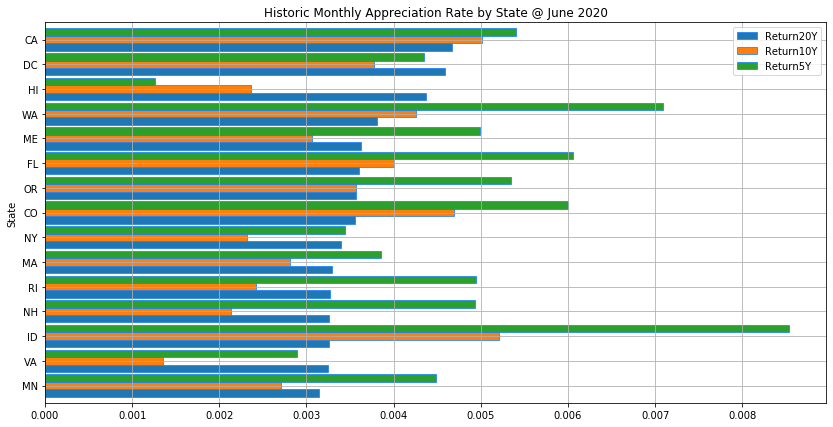

In [186]:
All_RegionsDF[['Return20Y','Return10Y','Return5Y']].groupby(level='State').mean().sort_values(by=['Return20Y'],ascending=True).dropna().tail(15).plot.barh(title='Historic Monthly Appreciation Rate by State @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

In [22]:
All_RegionsDF.loc[idx['CA',:,:,'Huntington Beach',:]].sort_values(by=['Return5Y'],ascending=False).head(10)

RegionID  \
Metro                          CountyName    RegionName                     
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach           47913   
                                             Huntington Harbour    115720   

                                                                 SizeRank  \
Metro                          CountyName    RegionName                     
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach           16351   
                                             Huntington Harbour     17008   

                                                                                                  Address  \
Metro                          CountyName    RegionName                                                     
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach              Sunset Beach, Huntington Beach, CA   
                                             Huntington Harbour  Huntington Harbour, Huntington Beach, CA   

                                                                 AllHPrice  \
Metro                          CountyName    RegionName                      
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach        1817004.0   
                                             Huntington Harbour  1614321.0   

                                                                  1brPrice  \
Metro                          CountyName    RegionName                      
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach        1648876.0   
                                             Huntington Harbour        NaN   

                                                                  2brPrice  \
Metro                          CountyName    RegionName                      
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach        1467585.0   
                                             Huntington Harbour   798550.0   

                                                                  3brPrice  \
Metro                          CountyName    RegionName                      
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach        1600721.0   
                                             Huntington Harbour  1353106.0   

                                                                 AllHPriceStd  \
Metro                          CountyName    RegionName                         
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach            1.743114   
                                             Huntington Harbour      1.387765   

                                                                 3brPriceStd  \
Metro                          CountyName    RegionName                        
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach           2.191802   
                                             Huntington Harbour     1.542965   

                                                                 2brPriceStd  \
Metro                          CountyName    RegionName                        
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach           3.790593   
                                             Huntington Harbour     0.903271   

                                                                 1brPriceStd  \
Metro                          CountyName    RegionName                        
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach           3.576763   
                                             Huntington Harbour          NaN   

                                                                 Sigma10Y  \
Metro                          CountyName    RegionName                     
Los Angeles-Long Beach-Anaheim Orange County Sunset Beach        0.010385   
                                             Huntington Harbour  0.008113   

                                                                 Return10Y  \
Metro                          CountyName    RegionName                      
Los A

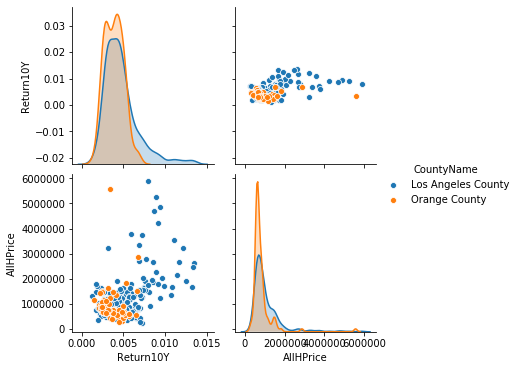

In [23]:
sns.pairplot(All_RegionsDF[['Return10Y','AllHPrice']].xs(('CA','Los Angeles-Long Beach-Anaheim'), level=('State','Metro'), axis=0).reset_index(), hue='CountyName')

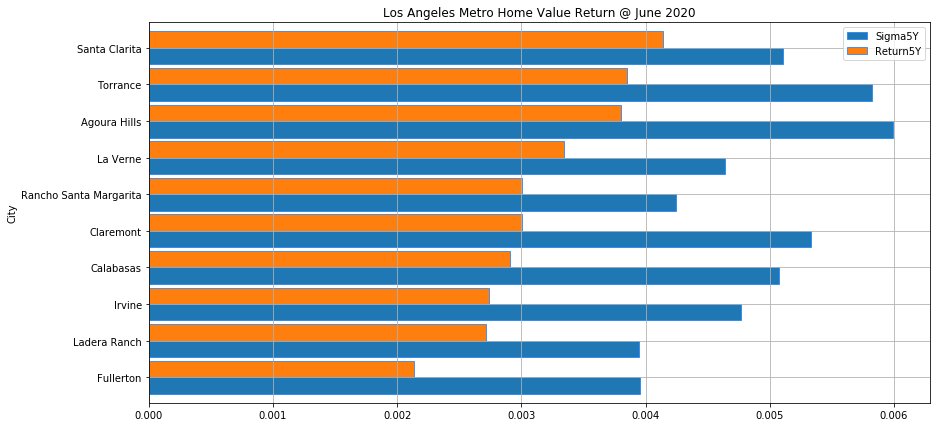

In [873]:
All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['Sigma5Y','Return5Y']].groupby(level='City').mean().sort_values(by=['Return5Y'],ascending=True).head(10).plot.barh(title='Los Angeles Metro Home Value Return @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

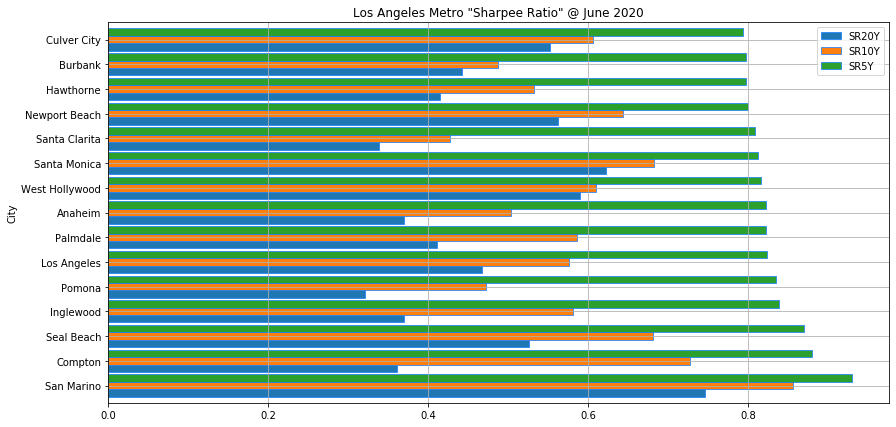

In [224]:
All_RegionsDF.loc[idx['CA','Los Angeles-Long Beach-Anaheim',:,:,:],['SR20Y','SR10Y','SR5Y']].groupby(level='City').mean().sort_values(by=['SR5Y'],ascending=False).head(15).plot.barh(title='Los Angeles Metro "Sharpee Ratio" @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

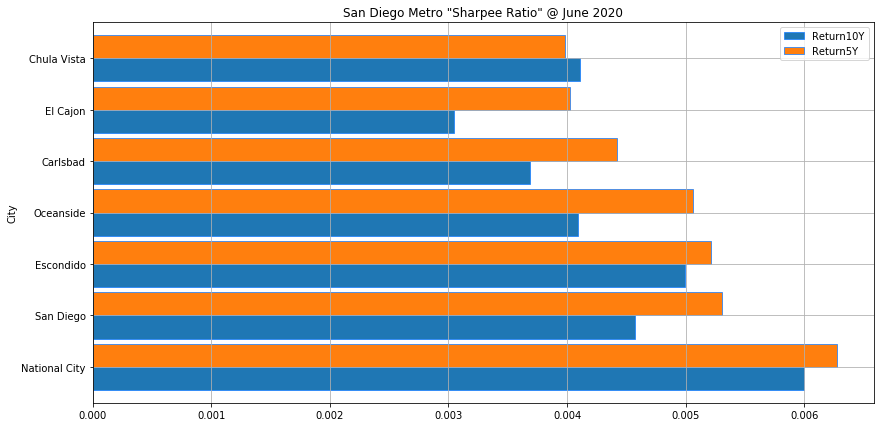

In [225]:
All_RegionsDF.loc[idx['CA','San Diego-Carlsbad',:,:,:],['Return10Y','Return5Y']].groupby(level='City').mean().sort_values(by=['Return5Y'],ascending=False).plot.barh(title='San Diego Metro "Sharpee Ratio" @ June 2020', grid=True, figsize=(14,7), width=0.9, linewidth=0.75, edgecolor=(0.1,0.5,1,1))

In [226]:
All_RegionsDF[['Return5Y','AllHPrice']].xs('Chula Vista', level='City', axis=0).sort_values(by=['Return5Y'],ascending=False)

Return5Y  \
State Metro              CountyName       RegionName                              
CA    San Diego-Carlsbad San Diego County Northwest                    0.005199   
                                          Southwest                    0.005165   
                                          Terra Nova                   0.004927   
                                          East Lake I                  0.004763   
                                          Lynwood Hills                0.004600   
                                          Sunbow I                     0.004509   
                                          Rancho Del Rey I             0.004507   
                                          Otay Ranch Village 5         0.004343   
                                          Amphitheater and Water Park  0.004288   
                                          Paseo Ranchoero              0.004234   
                                          Sunbow II                    0.004094   
                                          Eastlake Greens              0.004050   
                                          Eastlake Trails              0.004026   
                                          Otay Ranch                   0.004008   
                                          Eastlake Vistas              0.003934   
                                          Otay Ranch Village 1         0.003931   
                                          Eastlake Land Swap           0.003749   
                                          San Miguel Ranch             0.003707   
                                          Eastlake Woods West          0.003591   
                                          Bella Lago                   0.003578   
                                          Eastlake Woods               0.003418   
                                          Rancho Del Rey II            0.003063   
                                          Rolling Hills Ranch          0.003021   
                                          Bonita Long Canyon           0.002827   
                                          Fenton St                    0.001953   

                                                                       AllHPrice  
State Metro              CountyName       RegionName                              
CA    San Diego-Carlsbad San Diego County Northwest                     526545.0  
                                          Southwest                     511574.0  
                                          Terra Nova                    593300.0  
                                          East Lake I                   525058.0  
                                          Lynwood Hills                 596481.0  
                                          Sunbow I                      658243.0  
                                          Rancho Del Rey I              605003.0  
                                          Otay Ranch Village 5          586741.0  
                                          Amphitheater and Water Park   619434.0  
                                          Paseo Ranchoero               629712.0  
                                          Sunbow II                     651062.0  
                                          Eastlake Greens               582374.0  
                                          Eastlake Trails               646798.0  
                                          Otay Ranch                    594976.0  
                                          Eastlake Vistas               580474.0  
                                          Otay Ranch Village 1          655512.0  
                                          Eastlake Land Swap            459424.0  
                                          San Miguel Ranch              709991.0  
                                          Eastlake Woods West           673265.0  
                                          Bella Lago                   1220561.0  
   

### 2.2 Downloading Coordinates data from Geocoder

With the address information aggregated under the 'Address' column we can execute the function for querying coordinates information. For this, a get_coords function was defined, with the goal of bypassing the timeout and recurssion errors that endpoints generate when hiting the service rate quota.

In [49]:
def get_coords(address, attempt=1, max_attempts=5):
    geolocator = Nominatim(user_agent="my-application")
    gmaps = googlemaps.Client(key='')

    try:
        gmaps_result = gmaps.geocode(str(address))
        if len(gmaps_result) > 0:
            return list(gmaps_result[0]['geometry']['location'].values())
        else:
            try:
                nom_result = geolocator.geocode(str(address),timeout=1000)
                if nom_result == None:
                    return [np.NaN, np.NaN]
                else:
                    return list([nom_result.latitude, nom_result.longitude])
            except GeocoderTimedOut:
                time.sleep(1)
                if attempt <= max_attempts:
                    return get_coords(address, attempt=attempt+1)
                raise
    except:
        try:
            nom_result = geolocator.geocode(str(address),timeout=1000)
            if nom_result == None:
                return [np.NaN, np.NaN]
            else:
                return list([nom_result.latitude, nom_result.longitude])
        except GeocoderTimedOut:
            time.sleep(1)
            if attempt <= max_attempts:
                return get_coords(address, attempt=attempt+1)
            raise

In [51]:
All_RegionsDF.loc[idx['CA',:,:,'Huntington Beach',:],['Address']].apply(lambda x: get_coords(x), axis=1)


State  Metro                           CountyName     City              RegionName        
CA     Los Angeles-Long Beach-Anaheim  Orange County  Huntington Beach  Sunset Beach          [33.7207336, -118.0735739]
                                                                        Huntington Harbour    [33.7211288, -118.0642292]
dtype: object

In [66]:
All_RegionsDF['Coords'] = All_RegionsDF[['Address']].apply(lambda x: get_coords(x), axis=1)

In [113]:
All_RegionsDF[['Coords']].head()

,,,,,Coords
State,Metro,CountyName,City,RegionName,
TX,Dallas-Fort Worth-Arlington,Dallas County,Dallas,Northeast Dallas,"[32.8509234, -96.75285369999999]"
AZ,Phoenix-Mesa-Scottsdale,Maricopa County,Phoenix,Maryvale,"[33.4898258, -112.2264794]"
NV,Las Vegas-Henderson-Paradise,Clark County,Las Vegas,Paradise,"[nan, nan]"
NY,New York-Newark-Jersey City,New York County,New York,Upper West Side,"[40.7870106, -73.9753676]"
CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,Los Angeles,South Los Angeles,"[33.9891116, -118.2914872]"


In [112]:
print('A total of {} coordinates, out of {} neighborhoods where found.'.format(len(All_RegionsDF[['Coords']].apply(lambda x: x.str[1]).dropna()),len(All_RegionsDF[['Coords']])))

A total of 15980 coordinates, out of 16147 neighborhoods where found.


In [486]:
# Backup this hard earned Dataframe
All_RegionsDF.to_pickle("./All_Regions.pkl")

In [5]:
All_RegionsDF = pd.read_pickle("./All_Regions.pkl")

### 2.3 Individual City Data Validation and Testing

Finally we will inspect the data generated so far for two neighborhoods that will be used to analyze and explore in the second part of this research.

#### 2.3.1 Neighborhoods in each city's data set

#### 2.3.1 Here we will extract time window for year 2020 for the neighborhoods contained in the city of Austin. 

### Time Series from Monthly Price Data

## 3.0 Data Exploration

### 3.1 Explore and cluster the neighborhoods in Los Angeles

Since latitude and Longitude infromation was captured for Postal Codes which are matched 1 to 1 with more than one neighborhood, we will focus on exploring those instead of neighborhoods.

Foursquare Venues Data Download Function Definition: 

In [655]:
CLIENT_ID = '' #your Foursquare ID
CLIENT_SECRET = '' #your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
def getNearbyVenue(RegID, latitude, longitude, radius=500):
    if np.isnan(latitude):
        return None
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        LIMIT, # limit of number of venues returned by Foursquare API
        radius # define radius
        )  
    # make the GET request
    count = 0
    while count < 20:
        try:
            results = requests.get(url).json()["response"]
            if results.get('groups'):
                results = results['groups'][0]['items']
                venues_list=[]
                # return only relevant information for each nearby venue
                venues_list.append([(
                   RegID, 
            #        latitude,
            #        longitude,
                   v['venue']['name'],
                   v['venue']['location']['lat'], 
                   v['venue']['location']['lng'],  
                   v['venue']['categories'][0]['name']) for v in results])
                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['RegionID', 
            #                   'Region Latitude', 
            #                   'Region Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
                return(nearby_venues)

            else:
                time.sleep(3)
                count+=1
                continue
        except:
            return None
            
    return None

Executing Function for finding venue infromation by each Toronto Borough.

In [654]:
getNearbyVenue(RegID = All_RegionsDF['RegionID'][0],
                                   latitude = All_RegionsDF['Coords'][0][0],
                                   longitude = All_RegionsDF['Coords'][0][1]
                                  )

,RegionID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,274772,Latin Deli,32.856268,-96.749500,Latin American Restaurant
1,274772,Keller's Drive-In,32.856568,-96.747423,Burger Joint
2,274772,Target,32.857077,-96.752644,Big Box Store
3,274772,Subway,32.856357,-96.751170,Sandwich Place
4,274772,Baker's Ribs,32.856203,-96.748667,BBQ Joint
5,274772,ALDI,32.856012,-96.749761,Grocery Store
6,274772,Mario Bros Tacos,32.857774,-96.748023,Taco Place
7,274772,Socialite Salon,32.857546,-96.753875,Salon / Barbershop
8,274772,Supercuts,32.856667,-96.751058,Salon / Barbershop
9,274772,Chipotle Mexican Grill,32.857332,-96.749599,Mexican Restaurant


In [674]:
# All regions all venues data download!
All_Regions_Venues = All_RegionsDF.groupby(All_RegionsDF.index.names).apply(lambda x: getNearbyVenue(x['RegionID'][0],x['Coords'][0][0],x['Coords'][0][1]))

In [684]:
print(All_RegionsDF.shape)
print(All_Regions_Venues.shape)

(16147, 21)
(530277, 5)


In [689]:
pd.get_dummies(All_Regions_Venues['Venue Category'].iloc[1:100])

American Restaurant  \
State Metro     CountyName        City      RegionName                                
AK    Anchorage Anchorage Borough Anchorage Abbott Loop     1                     0   
                                                            2                     0   
                                                            3                     0   
                                            Airport Heights 0                     0   
                                                            1                     0   
                                                            2                     0   
                                                            3                     0   
                                                            4                     0   
                                                            5                     0   
                                                            6                     0   
                                            Basher          0                     0   
                                            Bayshore-Klatt  0                     0   
                                                            1                     0   
                                                            2                     0   
                                                            3                     0   
                                                            4                     0   
                                                            5                     0   
                                                            6                     0   
                                                            7                     0   
                                                            8                     0   
                                                            9                     0   
                                                            10                    0   
                                                            11                    0   
                                                            12                    0   
                                            Bear Valley     0                     0   
                                                            1                     0   
                                                            2                     0   
                                            Birchwood       0                     0   
                                                            1                     0   
                                                            2                     0   
                                                            3                     0   
                                            Campbell Park   0                     0   
                                                            1                     0   
                                                            2                     0   
                                                            3                     0   
                                                            4                     0   
                                                            5                     0   
                                                            6                     0   
                                                            7                     0   
                                                            8                     0   
                                                            9                     0   
                                                            10                    0   
                                                            11                    0   
                                                            12                    0   
                                                            13

In [681]:
# Backup this hard earned Dataframe
All_Regions_Venues.to_pickle("./All_Regions_Venues.pkl")

In [2]:
All_Regions_Venues = pd.read_pickle("./All_Regions_Venues.pkl")

In [3]:
All_Regions_Venues.drop(All_Regions_Venues[All_Regions_Venues['Venue Category']=='City'].index,inplace=True)

In [6]:
print('There are {} unique categories.'.format(len(All_Regions_Venues['Venue Category'].unique())))
# one hot encoding
All_Regions_Venues_onehot = pd.get_dummies(All_Regions_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# All_Regions_Venues_onehot['RegionName'] = All_Regions_Venues['RegionName']

All_Regions_Venues_grouped = All_Regions_Venues_onehot.groupby(All_RegionsDF.index.names).mean()
All_Regions_Venues_grouped.head()

There are 696 unique categories.


ATM  Acai House  \
State Metro     CountyName        City      RegionName                         
AK    Anchorage Anchorage Borough Anchorage Abbott Loop      0.0         0.0   
                                            Airport Heights  0.0         0.0   
                                            Basher           0.0         0.0   
                                            Bayshore-Klatt   0.0         0.0   
                                            Bear Valley      0.0         0.0   

                                                             Accessories Store  \
State Metro     CountyName        City      RegionName                           
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                    0.0   
                                            Airport Heights                0.0   
                                            Basher                         0.0   
                                            Bayshore-Klatt                 0.0   
                                            Bear Valley                    0.0   

                                                             Acupuncturist  \
State Metro     CountyName        City      RegionName                       
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                0.0   
                                            Airport Heights            0.0   
                                            Basher                     0.0   
                                            Bayshore-Klatt             0.0   
                                            Bear Valley                0.0   

                                                             Adult Boutique  \
State Metro     CountyName        City      RegionName                        
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                 0.0   
                                            Airport Heights             0.0   
                                            Basher                      0.0   
                                            Bayshore-Klatt              0.0   
                                            Bear Valley                 0.0   

                                                             Advertising Agency  \
State Metro     CountyName        City      RegionName                            
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                     0.0   
                                            Airport Heights                 0.0   
                                            Basher                          0.0   
                                            Bayshore-Klatt                  0.0   
                                            Bear Valley                     0.0   

                                                             Afghan Restaurant  \
State Metro     CountyName        City      RegionName                           
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                    0.0   
                                            Airport Heights                0.0   
                                            Basher                         0.0   
                                            Bayshore-Klatt                 0.0   
                                            Bear Valley                    0.0   

                                                             African Restaurant  \
State Metro     CountyName        City      RegionName                            
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                     0.0   
                                            Airport Heights                 0.0   
                                            Basher                          0.0   
                                            Bayshore-Klatt                  0.0   
                                            Bear Valley                     0.0   

                                                             Airport  \
State Metro  

It would be interesting to explore what are the most common type of venues by borough. Next we will define a function for sorting venues by frequency and create a new dataframe for boroughts with corresponding 10 most common venue categories.

In [7]:
All_Regions_Venues_grouped.xs('Chula Vista', level='City', axis=0, drop_level=False).groupby(level='City').mean()

,ATM,Acai House,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Cha Chaan Teng,Chaat Place,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Churrascaria,Cidery,Circus,Circus School,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Tennis Court,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cricket Ground,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,F

In [122]:
def drop_zeroes(regionVenuesGrouped):
#     return regionVenuesGrouped.T[(regionVenuesGrouped.T != 0).T.any()].sort_values(regionVenuesGrouped.T.columns[0],ascending=False).T
    return regionVenuesGrouped.T[(regionVenuesGrouped.T != 0).T.any()].T

drop_zeroes(All_Regions_Venues_grouped.iloc[[1]])

,,,,,Bakery,Food,Gas Station,Park,Sandwich Place,State
State,Metro,CountyName,City,RegionName,,,,,,
AK,Anchorage,Anchorage Borough,Anchorage,Airport Heights,0.142857,0.428571,0.142857,0.142857,0.142857,AK


In [9]:
drop_zeroes(All_Regions_Venues_grouped.loc[[('CA','Los Angeles-Long Beach-Anaheim','Los Angeles County','San Marino','Lower Huntington')]])

,,,,,Amphitheater,Art Gallery,Art Museum,Botanical Garden,Café,Coffee Shop,Dumpling Restaurant,Food,Garden,Gift Shop,History Museum,Mexican Restaurant,Museum,Science Museum,Tea Room,Theater,Video Store
State,Metro,CountyName,City,RegionName,,,,,,,,,,,,,,,,,
CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,San Marino,Lower Huntington,0.026316,0.078947,0.026316,0.026316,0.052632,0.078947,0.026316,0.026316,0.421053,0.026316,0.026316,0.026316,0.026316,0.026316,0.052632,0.026316,0.026316


In [10]:
drop_zeroes(All_Regions_Venues_grouped.xs('San Diego County', level='CountyName', axis=0, drop_level=False).groupby(level='City').mean())

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bay,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cave,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Dry Cleaner,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paintball Field,Paper / Office Supplies Store,Park,Parking,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizz

### 3.X Find Correlations between Venues and Statistics

In this section we will explore any relations between appreciation, price and venues/features in these areas.

In [31]:
All_Regions_merged = All_Regions_Venues_grouped.copy()
All_Regions_merged = All_Regions_merged.join(All_RegionsDF)
print(All_Regions_merged.shape)
All_Regions_merged.head()

(15851, 717)


ATM  Acai House  \
State Metro     CountyName        City      RegionName                         
AK    Anchorage Anchorage Borough Anchorage Abbott Loop      0.0         0.0   
                                            Airport Heights  0.0         0.0   
                                            Basher           0.0         0.0   
                                            Bayshore-Klatt   0.0         0.0   
                                            Bear Valley      0.0         0.0   

                                                             Accessories Store  \
State Metro     CountyName        City      RegionName                           
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                    0.0   
                                            Airport Heights                0.0   
                                            Basher                         0.0   
                                            Bayshore-Klatt                 0.0   
                                            Bear Valley                    0.0   

                                                             Acupuncturist  \
State Metro     CountyName        City      RegionName                       
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                0.0   
                                            Airport Heights            0.0   
                                            Basher                     0.0   
                                            Bayshore-Klatt             0.0   
                                            Bear Valley                0.0   

                                                             Adult Boutique  \
State Metro     CountyName        City      RegionName                        
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                 0.0   
                                            Airport Heights             0.0   
                                            Basher                      0.0   
                                            Bayshore-Klatt              0.0   
                                            Bear Valley                 0.0   

                                                             Advertising Agency  \
State Metro     CountyName        City      RegionName                            
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                     0.0   
                                            Airport Heights                 0.0   
                                            Basher                          0.0   
                                            Bayshore-Klatt                  0.0   
                                            Bear Valley                     0.0   

                                                             Afghan Restaurant  \
State Metro     CountyName        City      RegionName                           
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                    0.0   
                                            Airport Heights                0.0   
                                            Basher                         0.0   
                                            Bayshore-Klatt                 0.0   
                                            Bear Valley                    0.0   

                                                             African Restaurant  \
State Metro     CountyName        City      RegionName                            
AK    Anchorage Anchorage Borough Anchorage Abbott Loop                     0.0   
                                            Airport Heights                 0.0   
                                            Basher                          0.0   
                                            Bayshore-Klatt                  0.0   
                                            Bear Valley                     0.0   

                                                             Airport  \
State Metro  

In [32]:
venues_feat = All_Regions_Venues_grouped.columns.values

In [42]:
All_Regions_merged[np.append(['Return5Y'],venues_feat)].dropna().shape

(15229, 697)

In [43]:
multi_lm = LinearRegression()
data = All_Regions_merged[np.append(['Return5Y'],venues_feat)].dropna()
multi_lm.fit(data[venues_feat],data['Return5Y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [252]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def linreg_by_features (data,factor):
    z_train, z_test, y_train, y_test = train_test_split(data[venues_feat], data[factor], test_size=0.1, random_state=1)
    lm = LinearRegression()
    lm.fit(z_train, y_train)
    y_predict = lm.predict(z_test)
    mean_squared_error(y_test, y_predict)
    # Find the R^2
    print('The R-square is: ', lm.score(z_train,y_train))
    print('The MSE is: ', mean_squared_error(y_test, y_predict))
    coeffs = pd.DataFrame(lm.coef_, z_train.columns, columns=['Coefficient'])
    return coeffs.sort_values(by='Coefficient', ascending = False)

allcoeffs = linreg_by_features(All_Regions_merged.dropna()[np.append(['Return5Y'],venues_feat)],'Return5Y')
allcoeffs.head(10)

The R-square is:  0.28613813822580914
The MSE is:  7.266983542389003e-06


,Coefficient
Brasserie,0.240586
Cidery,0.234273
Pelmeni House,0.233687
Hungarian Restaurant,0.214942
Travel Lounge,0.190531
Physical Therapist,0.179497
Festival,0.174966
Fraternity House,0.161044
Floating Market,0.160289
Airport Food Court,0.156829


In [85]:
cacoeffs = linreg_by_features(All_Regions_merged.loc['CA'].dropna()[np.append(['Return10Y'],venues_feat)],'Return10Y')
cacoeffs.head()

The R-square is:  0.7850707799605705
The MSE is:  3.2098066271130624e+16


,Coefficient
Airport Food Court,2.470751e+11
Border Crossing,2.252678e+11
Boarding House,1.281968e+11
Betting Shop,1.000184e+11
Campaign Office,8.311324e+10


In [110]:
linreg_by_features(All_Regions_merged.loc['TX'].dropna()[np.append(['Return10Y'],venues_feat)],'Return10Y').head(10)

The R-square is:  0.9916574967876474
The MSE is:  2.3830557446388052e+16


,Coefficient
Adult Boutique,2.271268e+10
Alternative Healer,1.281557e+10
Arts & Entertainment,8.405111e+09
College Academic Building,5.105994e+09
Camera Store,4.915312e+09
African Restaurant,4.665573e+09
Accessories Store,4.452355e+09
Baseball Stadium,4.089987e+09
Beach Bar,3.994009e+09
Auditorium,3.367863e+09


In [108]:
linreg_by_features(All_Regions_merged.xs(('Los Angeles County'),level='CountyName',axis=0).dropna()[np.append(['Return10Y'],venues_feat)],'Return10Y').head(10)

The R-square is:  0.9295821763479168
The MSE is:  4.7416161165764294e+17


,Coefficient
African Restaurant,7.271625e+10
Apres Ski Bar,5.869320e+10
Antique Shop,3.088265e+10
Airport,2.280459e+10
Airport Food Court,1.690294e+10
Assisted Living,1.535607e+10
Astrologer,1.479976e+10
French Restaurant,1.326457e+10
Bus Line,1.273838e+10
New American Restaurant,1.208828e+10


In [125]:
linreg_by_features(All_Regions_merged.xs(('San Diego County'),level='CountyName',axis=0).dropna()[np.append(['Return10Y'],venues_feat)],'Return10Y').head(10)

The R-square is:  0.9781105499265841
The MSE is:  2.47898978241983e+18


,Coefficient
Acupuncturist,6.097013e+10
Afghan Restaurant,4.997655e+10
Bridge,4.734772e+10
Auto Dealership,4.689487e+10
Advertising Agency,3.786746e+10
Building,3.296960e+10
Airport,3.188956e+10
Beer Store,2.955266e+10
Acai House,2.911969e+10
Airport Gate,2.689039e+10


### 3.2 Clustering Neighborhoods into groups by venue types charactersitics.

Define k=10 clusters for the total of 10 boroughs we collected venue infromation for.

In [126]:
All_Regions_Venues_cluster.shape

(14165, 701)

In [257]:
All_Regions_Venues_cluster = All_Regions_merged[np.append(['AllHPriceStd','Sigma5Y','Sigma10Y','Return5Y','Return10Y'],venues_feat)].dropna()
print(All_Regions_Venues_cluster.shape)

# Clusters w/ average of 10 elements. Then 14165/10 ~ 1400 clusters 
kclusters = 1400

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(All_Regions_Venues_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

(14118, 701)


array([1222,  132,  196, 1079,  830, 1135,  476,  865,  408,  237],
      dtype=int32)

In [262]:
# add clustering labels
All_Regions_Venues_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [263]:
All_Regions_Venues_cluster.xs('Echo Park', level='RegionName', axis=0)

,,,,Cluster Labels,AllHPriceStd,Sigma5Y,Sigma10Y,Return5Y,Return10Y,ATM,Acai House,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campaign Office,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Cemetery,Cha Chaan Teng,Chaat Place,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Christmas Market,Church,Churrascaria,Cidery,Circus,Circus School,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Tennis Court,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cricket Ground,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Fraternity House,French Restaura

In [283]:
All_Regions_Venues_cluster[All_Regions_Venues_cluster['Cluster Labels']==784].mean().sort_values(ascending=False).head(10)

Cluster Labels         784.000000
Coffee Shop              0.071607
Pizza Place              0.036009
Mexican Restaurant       0.030702
Bar                      0.029504
American Restaurant      0.029200
Park                     0.029199
Café                     0.023246
Sandwich Place           0.021583
Hotel                    0.019246
dtype: float64

In [271]:
drop_zeroes(All_Regions_Venues_cluster.groupby(['Cluster Labels']).mean().sort_values(by=['Return10Y'],ascending=False).head(10))

,AllHPriceStd,Sigma5Y,Sigma10Y,Return5Y,Return10Y,Airport Terminal,American Restaurant,Baseball Field,Beach,Bed & Breakfast,Botanical Garden,Business Service,Clothing Store,Construction & Landscaping,Diner,Dive Bar,Dog Run,Farmers Market,Food Court,Food Truck,Garden,Garden Center,Golf Course,Gym / Fitness Center,Harbor / Marina,Historic Site,Home Service,Hotel,Luggage Store,Music Store,Noodle House,Other Great Outdoors,Park,Pet Service,Playground,Scenic Lookout,Seafood Restaurant,Shopping Mall,State / Provincial Park,Steakhouse,Surf Spot,Tea Room,Tennis Court,Trail
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
698,5.177075,0.011882,0.012403,0.009551,0.009448,0.0,0.000,0.00,0.428571,0.0,0.000000,0.000,0.000,0.000,0.000000,0.0,0.0,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.285714,0.0,0.000000,0.142857,0.00,0.142857,0.000000,0.000000,0.000000
902,-0.991728,0.012160,0.013749,0.010570,0.009150,0.0,0.000,0.00,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000000,0.0,0.0,0.25,0.25,0.000000,0.000000,0.25,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.250000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1371,2.203377,0.011587,0.012485,0.009878,0.008952,0.0,0.000,0.00,0.000000,0.0,0.000000,0.000,0.125,0.000,0.000000,0.0,0.0,0.00,0.00,0.083333,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.416667,0.00,0.000000,0.083333,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.291667
1286,5.683160,0.012876,0.012229,0.010386,0.008921,0.0,0.000,0.00,0.400000,0.2,0.000000,0.000,0.000,0.000,0.000000,0.0,0.2,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.2,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
682,4.942283,0.008911,0.011083,0.007949,0.008622,0.0,0.000,0.00,0.000000,0.0,0.041667,0.000,0.000,0.000,0.041667,0.0,0.0,0.00,0.00,0.041667,0.416667,0.00,0.000000,0.00,0.000,0.041667,0.000000,0.0,0.00,0.041667,0.041667,0.041667,0.083333,0.00,0.041667,0.041667,0.0,0.041667,0.000000,0.00,0.000000,0.041667,0.041667,0.000000
1019,2.576956,0.012872,0.012279,0.007955,0.008599,0.0,0.000,0.25,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000000,0.0,0.0,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.25,0.000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
1288,-0.830987,0.008049,0.010813,0.007155,0.007990,0.0,0.000,0.00,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000000,0.0,0.0,0.00,0.00,0.000000,0.000000,0.00,0.333333,0.00,0.000,0.000000,0.333333,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.333333,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
742,3.884158,0.013395,0.011644,0.011356,0.007926,0.2,0.000,0.00,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000000,0.2,0.0,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.6,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
451,6.532955,0.009859,0.011252,0.008122,0.007926,0.0,0.125,0.00,0.250000,0.0,0.000000,0.125,0.000,0.125,0.000000,0.0,0.0,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.125,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.250000


In [303]:
drop_zeroes(All_Regions_Venues_cluster[All_Regions_Venues_cluster['Cluster Labels']==902]).mean().sort_values(ascending=False).head(20)

Cluster Labels    902.000000
Scenic Lookout      0.250000
Garden Center       0.250000
Food Court          0.250000
Farmers Market      0.250000
Sigma10Y            0.013749
Sigma5Y             0.012160
Return5Y            0.010570
Return10Y           0.009150
AllHPriceStd       -0.991728
dtype: float64

In [301]:
drop_zeroes(All_Regions_merged.loc[All_Regions_Venues_cluster[All_Regions_Venues_cluster['Cluster Labels']==902].index.values])

,,,,,Farmers Market,Food Court,Garden Center,Scenic Lookout,RegionID,SizeRank,Address,AllHPrice,1brPrice,2brPrice,3brPrice,AllHPriceStd,3brPriceStd,2brPriceStd,1brPriceStd,Sigma10Y,Return10Y,SR10Y,Sigma20Y,Return20Y,SR20Y,Sigma5Y,Return5Y,SR5Y,Coords,lat,long
State,Metro,CountyName,City,RegionName,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA,Stockton-Lodi,San Joaquin County,Stockton,Waterloo,0.25,0.25,0.25,0.25,118842,2037,"Waterloo, Stockton, CA",230138,194858,220419,236931,-0.991728,-1.24211,-0.439545,0.247596,0.0137489,0.00914991,0.665503,0.0149273,NaN,NaN,0.0121596,0.0105703,0.869293,"[37.998784, -121.2283004]",37.9988,-121.228


### 3.3 Map use for visualizing neighborhoods and how they cluster together 

In [183]:
All_Regions_Venues_cluster[['lat','long']] = pd.DataFrame(All_Regions_merged['Coords'].tolist(), index=All_Regions_merged.index)

Finally we will display a map with the different classified groups color coded. It is evident that some correlation exists between geographical classification and venue-based classification. 

In [184]:
# create map
map_clusters = folium.Map(location=[42.423203, -99.921923], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
Data_to_Map = All_Regions_Venues_cluster[All_Regions_Venues_cluster['Cluster Labels']==784]
markers_colors = []
for lat, lon, poi, cluster in zip(Data_to_Map['lat'], Data_to_Map['long'], Data_to_Map.index.get_level_values('RegionName'), Data_to_Map['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
# download countries geojson file
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
world_geo = r'world_countries.json' # geojson file
# create a plain world map
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
world_map.choropleth(
    geo_data=world_geo,
    data=df_can,
    columns=['Country', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Immigration to Canada'
)

# display map
world_map